# Lecture 6: Minibatching and Decreasing Step Sizes

## CS4787 — Principles of Large-Scale Machine Learning Systems

$\newcommand{\R}{\mathbb{R}}$
$\newcommand{\norm}[1]{\left\|#1\right\|}$
$\newcommand{\Exv}[1]{\mathbf{E}\left[#1\right]}$

In [1]:
import numpy
import scipy
import matplotlib
from matplotlib import pyplot
import time

matplotlib.rcParams.update({'font.size': 18})

## Announcements

**Prelim Exam Starting Next Thursday**: Take-home, open-book exam covering everything we've done up to that point (but with a focus on things that have appeared in problem sets and programming assignments). More logistical details on Monday.

**Problem Set 2 Out.** This is a half-sized problem set, designed to both cover new material we're discussing in lecture Today and on Monday, and to be short enough to finish before the Prelim. After the Prelim, we'll get back on our usual biweekly schedule.

## Where we left off...

We looked at how stochastic gradient descent performs without assuming convexity. First, we did an analysis-of-the-loss-at-the-next-step of SGD to get (for $\alpha \le 1/L$)

$$\Exv{ f(w_{t+1}) }
  \le
  \Exv{ f(w_t) }
  -
  \frac{\alpha}{2} \Exv{ \norm{ \nabla f(w_t) }^2 }
  +
  \frac{\alpha^2 \sigma^2 L}{2}.$$

We got a final expression like 

$$\frac{1}{T} 
  \sum_{t = 0}^{T - 1}
  \Exv{ \norm{ \nabla f(w_t) }^2 }
  \le
  \frac{ 2 \left( f(w_0) - f^* \right) }{\alpha T}
  +
  \frac{\alpha \sigma^2 L}{2}.$$

### SGD for Strongly Convex Objectives

We want to get a sense of how SGD will perform in the "easy-to-analyze" case of strongly convex objectives, so that this will give us more intuition about how SGD behaves at scale. We start with:

$$\Exv{ f(w_{t+1}) }
  \le
  \Exv{ f(w_t) }
  -
  \frac{\alpha}{2} \Exv{ \norm{ \nabla f(w_t) }^2 }
  +
  \frac{\alpha^2 \sigma^2 L}{2}.$$

As we did when we analyzed gradient descent, we apply the Polyak–Lojasiewicz condition,

$$\norm{\nabla f(x)}^2 \ge 2 \mu \left( f(x) - f^* \right).$$

This gives us

$$\Exv{ f(w_{t+1}) }
  \le
  \Exv{ f(w_t) }
  -
  \mu \alpha \Exv{ f(w_t) - f^* }
  +
  \frac{\alpha^2 \sigma^2 L}{2}.$$

Subtracting $f^*$ from both sides,

$$\Exv{ f(w_{t+1}) - f^* }
  \le
  \Exv{ f(w_t) - f^* }
  -
  \mu \alpha \Exv{ f(w_t) - f^* }
  +
  \frac{\alpha^2 \sigma^2 L}{2}.$$
  
And gathering terms

$$\Exv{ f(w_{t+1}) - f^* }
  \le
  (1 - \mu \alpha) \Exv{ f(w_t) - f^* }
  +
  \frac{\alpha^2 \sigma^2 L}{2}.$$

So, we have this recurrence relation

$$\Exv{ f(w_{t+1}) - f^* }
  \le
  (1 - \mu \alpha) \Exv{ f(w_t) - f^* }
  +
  \frac{\alpha^2 \sigma^2 L}{2}$$
  
and it's a bit complicated to see what's going on. To make the writing a bit more terse, let $\rho_t$ denote the expected objective gap at timestep $t$, i.e. $\rho_t = \Exv{ f(w_t) - f^* }$. Then,

$$\rho_{t+1}
  \le
  (1 - \mu \alpha) \rho_t
  +
  \frac{\alpha^2 \sigma^2 L}{2}.$$

This is an example of a linear recurrence (albeit one with an inequality). To "solve" this sort of maths problem, we first find the fixed point: the $\rho$ where

$$\rho
  \le
  (1 - \mu \alpha) \rho
  +
  \frac{\alpha^2 \sigma^2 L}{2}.$$
  
It's pretty easy to see that the solution here is

$$\rho = \frac{1}{\mu \alpha} \cdot \frac{\alpha^2 \sigma^2 L}{2} = \frac{\alpha \sigma^2 L}{2 \mu}.$$

Subtracting this fixed point from both sides of our inequality gives us

$$\rho_{t+1} - \frac{\alpha \sigma^2 L}{2 \mu}
  \le
  (1 - \mu \alpha) \rho_t
  +
  \frac{\alpha^2 \sigma^2 L}{2} - \frac{\alpha \sigma^2 L}{2 \mu}.$$

This simplifies to

$$\rho_{t+1} - \frac{\alpha \sigma^2 L}{2 \mu}
  \le
  (1 - \mu \alpha) \left( \rho_t - \frac{\alpha \sigma^2 L}{2 \mu} \right).$$

So we're left with 

$$\rho_{t+1} - \frac{\alpha \sigma^2 L}{2 \mu}
  \le
  (1 - \mu \alpha) \left( \rho_t - \frac{\alpha \sigma^2 L}{2 \mu} \right).$$
  
And now we recognize the same geometric decay that we saw in the analysis of gradient descent! (That is, if $x_{t+1} \le c x_t$ for $c > 0$, then $x_K \le c^K x_0$.) Applying the same reasoning gives us

$$\rho_K - \frac{\alpha \sigma^2 L}{2 \mu}
  \le
  (1 - \mu \alpha)^K \left( \rho_0 - \frac{\alpha \sigma^2 L}{2 \mu} \right).$$

We can simplify this a little by dropping the subtracted term on the right,

$$\rho_K - \frac{\alpha \sigma^2 L}{2 \mu}
  \le
  \exp(-\mu \alpha K) \cdot \rho_0.$$

Now moving the subtracted term from the left to the right and substituting in our defintion of $\rho$,

$$\Exv{f(w_K) - f^*} \le (1 - \mu \alpha)^K (f(w_0) - f^*)+ \frac{\alpha \sigma^2 L}{2 \mu}.$$

We can simplify this a little more by leveraging the fact that $1 - \mu \alpha \le \exp(-\mu \alpha)$ so $(1 - \mu \alpha)^K \le \exp(-\mu \alpha)^K = \exp(-\mu \alpha K)$.

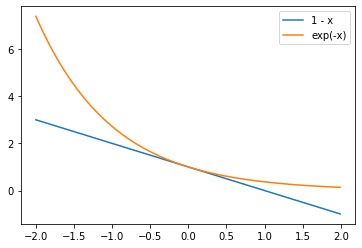

In [2]:
x = numpy.arange(-2,2,0.01)
pyplot.plot(x, 1-x, label="1 - x")
pyplot.plot(x, numpy.exp(-x), label="exp(-x)")
pyplot.legend()
pyplot.show()

This gives us

$$\Exv{f(w_K) - f^*} \le \exp(- \mu \alpha K) \cdot (f(w_0) - f^*)+ \frac{\alpha \sigma^2 L}{2 \mu}.$$

**What can we learn from this expression?**

<div style="text-align:center;font-size:200%;color:purple;font-weight:bold">Demo</div>

### Some takeaways:

$$\Exv{f(w_K) - f^*} \le \exp(- \mu \alpha K) \cdot (f(w_0) - f^*)+ \frac{\alpha \sigma^2 L}{2 \mu}.$$

* With gradient descent, if we wanted to get a solution of a desired level of accuracy we could just keep running until we observed a gradient small enough to satisfy our desires.

* With SGD using a fixed step size, this won't necessarily happen.

### One way to achieve a desired level of error...

...is to choose the hyperparameters $\alpha$ and $K$ as a function of the error. To achieve a guarantee that the expected loss gap will be no greater than $\epsilon$ from our formula

$$\Exv{f(w_K) - f^*} \le \exp(- \mu \alpha K) \cdot (f(w_0) - f^*)+ \frac{\alpha \sigma^2 L}{2 \mu},$$

it suffices to choose $\alpha$ and $K$ such that

$$\frac{\epsilon}{2} \ge \exp(- \mu \alpha K) \cdot (f(w_0) - f^*) \;\;\text{and}\;\; \frac{\epsilon}{2} \ge \frac{\alpha \sigma^2 L}{2 \mu}.$$

Now solving for $\alpha$ and $K$, and remembering that we already required $\alpha \le 1/L$, gives us

$$\alpha = \min\left( \frac{\epsilon \mu}{\sigma^2 L}, \frac{1}{L} \right) \;\;\text{and}\;\; K = \frac{1}{\alpha \mu} \cdot \log\left( \frac{2 (f(w_0) - f^*)}{\epsilon} \right).$$

In terms of the condition number $\kappa = L / \mu$, this gives us

$$K = \max\left(\frac{\sigma^2}{\epsilon \mu}, 1 \right) \cdot \kappa \cdot \log\left( \frac{2 (f(w_0) - f^*)}{\epsilon} \right)$$

In comparison, gradient descent had

$$K
  \ge
  \kappa
  \cdot
  \log\left( \frac{f(w_0) - f^*}{\epsilon} \right).$$

What can we conclude from this? Here's one thing that we can get: the asymptotic runtime used by these algorithms.
<span style="color:forestgreen; font-weight:bold;">For each of strongly convex GD/SGD, write a big-$\mathcal{O}$ expression for the total amount of compute that would be done by the algorithm to achieve error $\epsilon$.
Give your result in terms of $\epsilon$, $\kappa$ (for strongly-convex), $n$, and $\sigma^2$, treating all other expressions (such as $f(w_0) - f^*$) as constant.</span>

GD: $n \kappa \log\left( \frac{1}{\epsilon} \right)$

SGD: $\max(\frac{\sigma^2}{\epsilon},1) \cdot \kappa \cdot \log\left( \frac{1}{\epsilon} \right)$

<span style="color:forestgreen; font-weight:bold;">When might SGD be better than gradient descent and vice versa?</span>

# Minibatching!

One way to make SGD require fewer iterations is by decreasing the value of the gradient variance bound $\sigma^2$. A powerful way to do this is by using *minibatching*.

With minibatching, we use a sample of gradients of size larger than $1$. I.e.:

$$w_{t+1} = w_t - \alpha \cdot \frac{1}{B} \sum_{b=1}^B \nabla f_{i_{t,b}}(w_t) = w_t - \alpha \cdot \frac{1}{B} \sum_{b=1}^B \nabla_w \ell(w_t; x_{i_{t,b}}, y_{i_{t,b}}).$$

where $B$ is the *minibatch size* or *batch size*, and the $i_{t,b}$ are $b$ random variables drawn independently and uniformly from $\{1,\ldots,n\}$ (where $n$ is the size of the training set).

If the batch size is $B$, this results in a gradient estimator with variance $B$ times smaller.

* The nice consequence of this is that all of our proofs of convergence of SGD go through for minibatch SGD as well, with the variance $\sigma^2$ replaced by $\sigma^2/B$.

$$K = \max\left(\frac{\sigma^2}{\epsilon \mu B}, 1 \right) \cdot \kappa \cdot \log\left( \frac{2 (f(w_0) - f^*)}{\epsilon} \right).$$

How can we interpret this result?

* For sufficiently small $\epsilon$, minibatching with batch size $B$ decreases the number of iterations needed to get to objective gap $\epsilon$ by a factor of $B$.

* <span style="color:red;font-weight:bold">But doing minibatching with batch size $B$ increases the amount of compute we need to do by a factor of $B$!</span>

* Can also increase the batch size over time...eventually doing gradient descent.

So is there any point to using minibatching?

...

## Diminishing Step Size Schemes

Another thing that our analysis of SGD motivates us to do is to think of ways we could recover the asymptotic-convergence-to-the-global-optimum that gradient descent enjoys. Since we saw that constant-step-size SGD has convergence that is limited by a "noise ball" with size proportional to the step size, a natural way to try to fix this is to **decrease the step size over time**.

Let's suppose that we run SGD with a step size that changes over time, and let $\alpha_t$ denote the step size used at time $t$. Then the same analysis we used for constant-step-size SGD (on strongly convex objectives) will give us (where $\rho_t = \Exv{f(w_t) - f^*}$ is the expected objective gap at timestep $t$)

$$\rho_{t+1}
  \le
  (1 - \mu \alpha_t) \rho_t
  +
  \frac{\alpha_t^2 \sigma^2 L}{2}.$$

One way to try to "derive" what a good diminishing step size scheme will look like is to minimize this expression with respect to $\alpha_t$. Differentiating with respect to $\alpha_t$ to minimize gives

$$0 =
  - \mu \rho_t
  +
  \alpha_t \sigma^2 L,$$
  
  which simplifies to
  
$$\alpha_t = \frac{\mu \rho_t}{\sigma^2 L}.$$

Substituting this back into our inequality

$$\rho_{t+1}
  \le
  \left(1 - \mu \frac{\mu \rho_t}{\sigma^2 L} \right) \rho_t
  +
  \frac{\sigma^2 L}{2} \cdot \left( \frac{\mu \rho_t}{\sigma^2 L} \right)^2
  =
  \rho_t - \frac{\mu^2}{2 \sigma^2 L} \rho_t^2.$$

So we have

$$\rho_{t+1}
  \le
  \rho_t - \frac{\mu^2}{2 \sigma^2 L} \rho_t^2.$$
  
Inverting both sides gives us

$$\frac{1}{\rho_{t+1}}
  \ge
  \left( \rho_t - \frac{\mu^2}{2 \sigma^2 L} \rho_t^2 \right)^{-1}
  =
  \frac{1}{\rho_t} \cdot \left( 1 - \frac{\mu^2}{2 \sigma^2 L} \rho_t \right)^{-1}.$$

Noticing that $(1 - x)^{-1} \ge 1 + x$

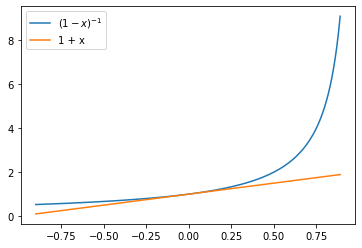

In [3]:
x = numpy.arange(-0.9,0.9,0.01)
pyplot.plot(x, 1/(1-x), label="$(1 - x)^{-1}$")
pyplot.plot(x, 1+x, label="1 + x")
pyplot.legend()
pyplot.show()

we can get 

$$\frac{1}{\rho_{t+1}}
  \ge
  \frac{1}{\rho_t} \cdot \left( 1 + \frac{\mu^2}{2 \sigma^2 L} \rho_t \right)
  =
  \frac{1}{\rho_t} + \frac{\mu^2}{2 \sigma^2 L}.$$

Finally, applying this recursively gives us

$$\frac{1}{\rho_K} \ge \frac{1}{\rho_0} + \frac{\mu^2 K}{2 \sigma^2 L} \ge \frac{\mu^2 K}{2 \sigma^2 L}.$$


So,

$$\Exv{f(w_K) - f^*} = \rho_K \le \frac{2 \sigma^2 L}{\mu^2 K},$$

and this assignment of $\rho_K$ suggests we should set $\alpha_t$ to be

$$\alpha_t = \frac{\mu}{\sigma^2 L} \cdot \frac{2 \sigma^2 L}{\mu^2 t} = \frac{2}{\mu t}.$$

This is called a $1/t$ step size scheme, and it's very common in ML and in optimization more generally!

* Use it, or other step size schemes like it, when you believe your loss function is fairly smooth and either strongly convex or "strongly-convex-like" nearby its local minima.